# RAPIDS cuML 
## Performance, Boundaries, and Correctness Benchmarks

**Description:** This notebook provides a simple and unified means of benchmarking single GPU cuML algorithms against their skLearn counterparts with the `cuml.benchmark` package in RAPIDS cuML. This enables quick and simple measurements of performance, validation of correctness, and investigation of upper bounds.

Each benchmark returns a Pandas `DataFrame` with the results. At the end of the notebook, these results are used to draw charts and output to a CSV file. 

Please refer to the [table of contents](#table_of_contents) for algorithms available to be benchmarked with this notebook.

In [1]:
import cuml
import pandas as pd

from cuml.benchmark.runners import SpeedupComparisonRunner
from cuml.benchmark.algorithms import algorithm_by_name
from cuml.common.import_utils import has_umap

import warnings
warnings.filterwarnings('ignore', 'Expected column ')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
print(cuml.__version__)

/home/jzedlewski/anaconda3/envs/cuml_dev/lib/python3.7/site-packages/treelite/gallery/__init__.py:7: FutureWarning: treelite.gallery.sklearn has been moved to treelite.sklearn. treelite.gallery.sklearn will be removed in version 1.1.
  FutureWarning)
/home/jzedlewski/anaconda3/envs/cuml_dev/lib/python3.7/site-packages/treelite/gallery/sklearn/__init__.py:9: FutureWarning: treelite.gallery.sklearn has been moved to treelite.sklearn. treelite.gallery.sklearn will be removed in version 1.1.
  FutureWarning)


0.15.0a+735.g0c4029b0a.dirty


In [2]:
os.environ["NUM_THREADS"] = "2"

In [3]:
N_REPS = 1  # Number of times each test is repeated

DATA_NEIGHBORHOODS = "blobs"
DATA_CLASSIFICATION = "classification"
DATA_REGRESSION = "regression"

INPUT_TYPE = "numpy"

benchmark_results = []

In [4]:
SMALL_ROW_SIZES = [2**x for x in range(12, 15)] # [2**x for x in range(14, 17)]
LARGE_ROW_SIZES = [2**x for x in range(18, 21)] # [2**x for x in range(18, 24, 2)]

SKINNY_FEATURES = [16, 64] # [32, 256]
WIDE_FEATURES = [100, 1000] # [1000, 10000]

VERBOSE = True
RUN_CPU = True
# Some CPU implementations may take hours to run, so they are disabled by default
# Set this variable to True to enable them
RUN_SLOW_CPU_ALGOS = True

In [5]:
import rmm

# Set pool allocator to True as desired
rmm.reinitialize(managed_memory=True)

In [11]:
def enrich_result(algorithm, runner, result):
    result["algo"] = algorithm
    result["dataset_name"] = runner.dataset_name
    result["input_type"] = runner.input_type
    return result

def execute_benchmark(algorithm, runner, run_cpu=RUN_CPU, **kwargs):
    """
    Executes a benchmark with the given parameters
    
    Parameters
    ----------
    
    algorithm : str or cuml.benchmark.algorithms.AlgorithmPair 
        Algorithm configuration to benchmark. String input must be 
        registered in cuml.benchmark.algorithms.all_algorithms()
        
    runner : cuml.benchmark.runners.SpeedupComparisonRunner
        Benchmark runner for computing results
        
    run_cpu : bool
        Whether to run the CPU benchmark. This will be
        ignored if a corresponding CPU benchmark is not
        provided.
    """
    
    algo = algorithm_by_name(algorithm) if isinstance(algorithm, str) else algorithm
    
    results = runner.run(algo, run_cpu=run_cpu, **kwargs)
    results = [enrich_result(algorithm, runner, result) for result in results]
    print(pd.DataFrame(results))
    
    benchmark_results.extend(results)

## Table of Contents<a id="table_of_contents"/>

### Benchmarks
1. [Neighbors](#neighbors)<br>
    1.1 [Nearest Neighbors - Brute Force](#nn_bruteforce)<br>
    1.2 [KNeighborsClassifier](#kneighborsclassifier)<br>
    1.3 [KNeighborsRegressor](#kneighborsregressor)<br>
2. [Clustering](#clustering)<br>
    2.1 [DBSCAN - Brute Force](#dbscan_bruteforce)<br>
    2.2 [K-Means](#kmeans)<br>
3. [Manifold Learning](#manifold_learning)<br>
    3.1 [UMAP - Unsupervised](#umap_unsupervised)<br>
    3.2 [UMAP - Supervised](#umap_supervised)<br>
    3.3 [T-SNE](#tsne)<br>
4. [Linear Models](#linear_models)<br>
    4.1 [Linear Regression](#linear_regression)<br>
    4.2 [Logistic Regression](#logistic_regression)<br>
    4.3 [Ridge Regression](#ridge_regression)<br>
    4.4 [Lasso Regression](#lasso_regression)<br>
    4.5 [ElasticNet Regression](#elasticnet_regression)<br>
    4.6 [Mini-batch SGD Classifier](#minibatch_sgd_classifier)<br>
5. [Decomposition](#decomposition)<br>
    5.1 [PCA](#pca)<br>
    5.2 [Truncated SVD](#truncated_svd)<br>
6. [Ensemble](#ensemble)<br>
    6.1 [Random Forest Classifier](#random_forest_classifier)<br>
    6.2 [Random Forest Regressor](#random_forest_regressor)<br>
    6.3 [FIL](#fil)<br>
    6.4 [Sparse FIL](#sparse_fil)<br>
7. [Random Projection](#random_projection)<br>
    7.1 [Gaussian Random Projection](#gaussian_random_projection)<br>
    7.2 [Sparse Random Projection](#sparse_random_projection)<br>
8. [SVM](#svm)<br>
    8.1 [SVC - Linear Kernel](#svc_linear_kernel)<br>
    8.2 [SVC - RBF Kernel](#svc_rbf_kernel)<br>
    8.3 [SVR - Linear Kernel](#svr_linear_kernel)<br>
    8.4 [SVR - RBF Kernel](#svr_rbf_kernel)<br>
    
### Chart & Store Results
9. [Convert to Pandas DataFrame](#convert_to_pandas)<br>
10. [Chart Results](#chart_results)<br>
11. [Output to CSV](#output_csv)<br>

## Neighbors<a id="neighbors"/>


### Nearest Neighbors - Brute Force<a id="nn_bruteforce"/>

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS,
)

execute_benchmark("NearestNeighbors", runner)

### KNeighborsClassifier<a id="kneighborsclassifier"/>

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("KNeighborsClassifier", runner)

### KNeighborsRegressor<a id="kneighborsregressor"/>

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("KNeighborsRegressor", runner)

## Clustering<a id="clustering"/>

### DBSCAN - Brute Force<a id="dbscan_bruteforce"/>

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("DBSCAN", runner, run_cpu=False)

### K-means Clustering<a id="kmeans"/>

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type="numpy",
    n_reps=N_REPS
)

execute_benchmark("KMeans", runner)

## Manifold Learning<a id="manifold_learning"/>

### UMAP - Unsupervised<a id="umap_unsupervised"/>
CPU benchmark requires UMAP-learn

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=1
)

execute_benchmark("UMAP-Unsupervised", runner, run_cpu=(RUN_CPU and has_umap()),
                  raise_on_error=True)

### UMAP - Supervised<a id="umap_supervised"/>
CPU benchmark requires UMAP-learn

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("UMAP-Supervised", runner, run_cpu=(RUN_CPU and has_umap()))

### T-SNE<a id="tsne"/>

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=[32, 256], 
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

algo = cuml.benchmark.algorithms.algorithm_by_name("TSNE")
algo.cuml_args["verbose"] = 1

execute_benchmark(algo, runner, run_cpu=False, verbose=1)

## Linear Models<a id="linear_models"/>

### Linear Regression<a id="linear_regression"/>

In [14]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("LinearRegression", runner)

    cu_time  cpu_time    speedup  n_samples  n_features              algo  \
0  0.035425  0.085243   2.406305     262144          16  LinearRegression   
1  0.068504  0.716991  10.466428     262144          64  LinearRegression   
2  0.035418  0.161019   4.546307     524288          16  LinearRegression   
3  0.115326  1.505372  13.053166     524288          64  LinearRegression   
4  0.058934  0.347174   5.890868    1048576          16  LinearRegression   
5  0.202951  3.111481  15.331195    1048576          64  LinearRegression   

  dataset_name input_type  
0   regression      numpy  
1   regression      numpy  
2   regression      numpy  
3   regression      numpy  
4   regression      numpy  
5   regression      numpy  


### Logistic Regression<a id="logistic_regression"/>

In [15]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("LogisticRegression", runner)

    cu_time  cpu_time    speedup  n_samples  n_features                algo  \
0  0.029142  0.215675   7.400790     262144          16  LogisticRegression   
1  0.060586  0.420636   6.942817     262144          64  LogisticRegression   
2  0.089050  0.441282   4.955449     524288          16  LogisticRegression   
3  0.143432  0.846501   5.901744     524288          64  LogisticRegression   
4  0.121681  0.968434   7.958777    1048576          16  LogisticRegression   
5  0.170286  1.840822  10.810168    1048576          64  LogisticRegression   

     dataset_name input_type  
0  classification      numpy  
1  classification      numpy  
2  classification      numpy  
3  classification      numpy  
4  classification      numpy  
5  classification      numpy  


### Ridge Regression<a id="ridge_regression"/>

In [16]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("Ridge", runner)

    cu_time  cpu_time   speedup  n_samples  n_features   algo dataset_name  \
0  0.017922  0.019099  1.065664     262144          16  Ridge   regression   
1  0.051440  0.088734  1.724994     262144          64  Ridge   regression   
2  0.028036  0.044593  1.590594     524288          16  Ridge   regression   
3  0.094273  0.175441  1.860980     524288          64  Ridge   regression   
4  0.049358  0.089087  1.804918    1048576          16  Ridge   regression   
5  0.156717  0.351482  2.242783    1048576          64  Ridge   regression   

  input_type  
0      numpy  
1      numpy  
2      numpy  
3      numpy  
4      numpy  
5      numpy  


### Lasso Regression<a id="lasso_regression"/>

In [12]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("Lasso", runner)

    cu_time  cpu_time   speedup  n_samples  n_features   algo dataset_name  \
0  0.040659  0.044492  1.094279     262144          16  Lasso   regression   
1  0.051930  0.332648  6.405702     262144          64  Lasso   regression   
2  0.028333  0.099688  3.518428     524288          16  Lasso   regression   
3  0.089100  0.508640  5.708619     524288          64  Lasso   regression   
4  0.053207  0.207546  3.900760    1048576          16  Lasso   regression   
5  0.164015  1.028839  6.272850    1048576          64  Lasso   regression   

  input_type  
0      numpy  
1      numpy  
2      numpy  
3      numpy  
4      numpy  
5      numpy  


### ElasticNet Regression<a id="elasticnet_regression"/>

In [13]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("ElasticNet", runner)

    cu_time  cpu_time   speedup  n_samples  n_features        algo  \
0  0.020974  0.043548  2.076286     262144          16  ElasticNet   
1  0.058258  0.249222  4.277929     262144          64  ElasticNet   
2  0.027716  0.099248  3.580900     524288          16  ElasticNet   
3  0.087102  0.516074  5.924964     524288          64  ElasticNet   
4  0.052778  0.207737  3.936025    1048576          16  ElasticNet   
5  0.169924  1.049255  6.174868    1048576          64  ElasticNet   

  dataset_name input_type  
0   regression      numpy  
1   regression      numpy  
2   regression      numpy  
3   regression      numpy  
4   regression      numpy  
5   regression      numpy  


### Mini-batch SGD Classifier<a id="minibatch_sgd_classifier"/>

In [20]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("MBSGDClassifier", runner)

/home/jzedlewski/code/rapidsai/cuml/python/cuml/benchmark/runners.py:115: UserWarning: run_cpu argument is set to True but no CPU implementation was provided. It's possible an additional library is needed but one could not be found. Benchmark will be executed with run_cpu=False
  warnings.warn("run_cpu argument is set to True but no CPU "


    cu_time  cpu_time  speedup  n_samples  n_features             algo  \
0  1.036744       0.0      0.0       4096          16  MBSGDClassifier   
1  1.014148       0.0      0.0       4096          64  MBSGDClassifier   
2  2.147093       0.0      0.0       8192          16  MBSGDClassifier   
3  2.706843       0.0      0.0       8192          64  MBSGDClassifier   
4  4.383487       0.0      0.0      16384          16  MBSGDClassifier   
5  4.075072       0.0      0.0      16384          64  MBSGDClassifier   

     dataset_name input_type  
0  classification      numpy  
1  classification      numpy  
2  classification      numpy  
3  classification      numpy  
4  classification      numpy  
5  classification      numpy  


## Decomposition<a id="decomposition"/>

### PCA<a id="pca"/>

In [17]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("PCA", runner)

    cu_time   cpu_time    speedup  n_samples  n_features algo dataset_name  \
0  0.086476   0.702798   8.127055     262144         100  PCA        blobs   
1  1.057676   5.833370   5.515271     262144        1000  PCA        blobs   
2  0.128374   1.619350  12.614306     524288         100  PCA        blobs   
3  1.991436  11.279368   5.663936     524288        1000  PCA        blobs   
4  0.407951   3.171927   7.775264    1048576         100  PCA        blobs   
5  3.972763  22.830528   5.746763    1048576        1000  PCA        blobs   

  input_type  
0      numpy  
1      numpy  
2      numpy  
3      numpy  
4      numpy  
5      numpy  


### Truncated SVD<a id="truncated_svd"/>

In [18]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("TSVD", runner)

    cu_time   cpu_time    speedup  n_samples  n_features  algo dataset_name  \
0  0.119193   0.693870   5.821421     262144         100  TSVD        blobs   
1  0.742136   3.933296   5.299965     262144        1000  TSVD        blobs   
2  0.163747   1.584700   9.677715     524288         100  TSVD        blobs   
3  1.286237   8.088941   6.288842     524288        1000  TSVD        blobs   
4  0.316578   3.393088  10.718026    1048576         100  TSVD        blobs   
5  2.598108  16.407786   6.315284    1048576        1000  TSVD        blobs   

  input_type  
0      numpy  
1      numpy  
2      numpy  
3      numpy  
4      numpy  
5      numpy  


## Ensemble<a id="ensemble"/>

### Random Forest Classifier<a id="random_forest_classifier"/>

In [19]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("RandomForestClassifier", runner)

    cu_time    cpu_time     speedup  n_samples  n_features  \
0  0.177315    7.953322   44.854080     262144          16   
1  0.513263   51.548505  100.432929     262144          64   
2  0.279564   18.289939   65.423107     524288          16   
3  0.895558  107.701110  120.261505     524288          64   
4  0.393317   50.144205  127.490722    1048576          16   
5  1.294974  306.656831  236.805380    1048576          64   

                     algo    dataset_name input_type  
0  RandomForestClassifier  classification      numpy  
1  RandomForestClassifier  classification      numpy  
2  RandomForestClassifier  classification      numpy  
3  RandomForestClassifier  classification      numpy  
4  RandomForestClassifier  classification      numpy  
5  RandomForestClassifier  classification      numpy  


### Random Forest Regressor<a id="random_forest_regressor"/>

In [21]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=LARGE_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("RandomForestRegressor", runner)

    cu_time   cpu_time    speedup  n_samples  n_features  \
0  0.297135   4.634442  15.597074     262144          16   
1  1.101298  16.774338  15.231428     262144          64   
2  0.539284   9.470040  17.560380     524288          16   
3  1.927899  36.961097  19.171697     524288          64   
4  0.747536  22.863606  30.585284    1048576          16   
5  3.405683  83.010268  24.374046    1048576          64   

                    algo dataset_name input_type  
0  RandomForestRegressor   regression      numpy  
1  RandomForestRegressor   regression      numpy  
2  RandomForestRegressor   regression      numpy  
3  RandomForestRegressor   regression      numpy  
4  RandomForestRegressor   regression      numpy  
5  RandomForestRegressor   regression      numpy  


### FIL<a id="fil"/>
CPU benchmark requires XGBoost Library

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("FIL", runner)

## Sparse FIL<a id="sparse_fil"/>
Requires TreeLite library

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("Sparse-FIL-SKL", runner)

## Random Projection<a id="random_projection"/>

### Gaussian Random Projection<a id="gaussian_random_projection"/>

In [22]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES,
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("GaussianRandomProjection", runner, run_cpu=False, verbose=True)

GaussianRandomProjection (n_samples=4096, n_features=16) [cpu=0.0, gpu=0.020132780075073242, speedup=0.0]
GaussianRandomProjection (n_samples=4096, n_features=64) [cpu=0.0, gpu=0.004724979400634766, speedup=0.0]
GaussianRandomProjection (n_samples=8192, n_features=16) [cpu=0.0, gpu=0.003981351852416992, speedup=0.0]
GaussianRandomProjection (n_samples=8192, n_features=64) [cpu=0.0, gpu=0.006320953369140625, speedup=0.0]
GaussianRandomProjection (n_samples=16384, n_features=16) [cpu=0.0, gpu=0.003882169723510742, speedup=0.0]
GaussianRandomProjection (n_samples=16384, n_features=64) [cpu=0.0, gpu=0.008761167526245117, speedup=0.0]
    cu_time  cpu_time  speedup  n_samples  n_features  \
0  0.020133       0.0      0.0       4096          16   
1  0.004725       0.0      0.0       4096          64   
2  0.003981       0.0      0.0       8192          16   
3  0.006321       0.0      0.0       8192          64   
4  0.003882       0.0      0.0      16384          16   
5  0.008761       0.

### Sparse Random Projection<a id="sparse_random_projection"/>

In [23]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES,
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("SparseRandomProjection", runner, run_cpu=False)

    cu_time  cpu_time  speedup  n_samples  n_features                    algo  \
0  0.242530       0.0      0.0       4096         100  SparseRandomProjection   
1  0.025747       0.0      0.0       4096        1000  SparseRandomProjection   
2  0.009108       0.0      0.0       8192         100  SparseRandomProjection   
3  0.044251       0.0      0.0       8192        1000  SparseRandomProjection   
4  0.015806       0.0      0.0      16384         100  SparseRandomProjection   
5  0.079758       0.0      0.0      16384        1000  SparseRandomProjection   

  dataset_name input_type  
0        blobs      numpy  
1        blobs      numpy  
2        blobs      numpy  
3        blobs      numpy  
4        blobs      numpy  
5        blobs      numpy  


## SVM<a id="svm"/>

### SVC - Linear Kernel<a id="svc_linear_kernel"/>

In [37]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("SVC-Linear", runner, run_cpu=RUN_SLOW_CPU_ALGOS)

    cu_time   cpu_time    speedup  n_samples  n_features        algo  \
0  0.295579   0.202856   0.686299       4096          16  SVC-Linear   
1  1.393995   1.345905   0.965502       4096          64  SVC-Linear   
2  0.502921   1.905206   3.788283       8192          16  SVC-Linear   
3  1.986276   7.713473   3.883384       8192          64  SVC-Linear   
4  0.538374   4.757145   8.836131      16384          16  SVC-Linear   
5  2.564842  37.799499  14.737553      16384          64  SVC-Linear   

     dataset_name input_type  
0  classification      numpy  
1  classification      numpy  
2  classification      numpy  
3  classification      numpy  
4  classification      numpy  
5  classification      numpy  


### SVC - RBF Kernel<a id="svc_rbf_kernel"/>

In [38]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("SVC-RBF", runner, run_cpu=RUN_SLOW_CPU_ALGOS)

    cu_time   cpu_time    speedup  n_samples  n_features     algo  \
0  0.074594   0.174590   2.340539       4096          16  SVC-RBF   
1  0.052657   0.639899  12.152242       4096          64  SVC-RBF   
2  0.102453   1.180838  11.525633       8192          16  SVC-RBF   
3  0.110839   3.696446  33.349581       8192          64  SVC-RBF   
4  0.212351   4.360883  20.536195      16384          16  SVC-RBF   
5  0.183340  12.225076  66.679869      16384          64  SVC-RBF   

     dataset_name input_type  
0  classification      numpy  
1  classification      numpy  
2  classification      numpy  
3  classification      numpy  
4  classification      numpy  
5  classification      numpy  


### SVR - Linear Kernel<a id="svr_linear_kernel"/>

In [39]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("SVR-Linear", runner, run_cpu=RUN_SLOW_CPU_ALGOS)

    cu_time  cpu_time   speedup  n_samples  n_features        algo  \
0  0.338098  0.138603  0.409950       4096          16  SVR-Linear   
1  1.763698  0.925166  0.524560       4096          64  SVR-Linear   
2  0.354691  0.280358  0.790431       8192          16  SVR-Linear   
3  2.674212  1.350024  0.504831       8192          64  SVR-Linear   
4  0.540443  0.600564  1.111244      16384          16  SVR-Linear   
5  2.988857  1.959144  0.655483      16384          64  SVR-Linear   

  dataset_name input_type  
0   regression      numpy  
1   regression      numpy  
2   regression      numpy  
3   regression      numpy  
4   regression      numpy  
5   regression      numpy  


### SVR - RBF Kernel<a id="svr_rbf_kernel"/>

In [40]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("SVR-RBF", runner, run_cpu=RUN_SLOW_CPU_ALGOS)

    cu_time   cpu_time     speedup  n_samples  n_features     algo  \
0  0.063401   0.711154   11.216674       4096          16  SVR-RBF   
1  0.058444   1.574319   26.936994       4096          64  SVR-RBF   
2  0.094380   2.789990   29.561272       8192          16  SVR-RBF   
3  0.101447   6.274509   61.850059       8192          64  SVR-RBF   
4  0.156145  10.969604   70.252631      16384          16  SVR-RBF   
5  0.155951  25.015144  160.403849      16384          64  SVR-RBF   

  dataset_name input_type  
0   regression      numpy  
1   regression      numpy  
2   regression      numpy  
3   regression      numpy  
4   regression      numpy  
5   regression      numpy  


## Charting & Storing Results<a id="charting_and_storing_results"/>

### Convert Results to Pandas DataFrame<a id="convert_to_pandas"/>

In [28]:
%matplotlib inline

In [29]:
df = pd.DataFrame(benchmark_results)

### Chart Results<a id="chart_results"/>

In [30]:
def chart_single_algo_speedup(df, algorithm):
    df = df.loc[df.algo == algorithm]
    df = df.pivot(index="n_samples", columns="n_features", values="speedup")
    axes = df.plot.bar(title="%s Speedup" % algorithm)

In [31]:
def chart_all_algo_speedup(df):
    df = df[["algo", "n_samples", "speedup"]].groupby(["algo", "n_samples"]).mean()
    df.plot.bar()

In [32]:
chart_single_algo_speedup(df, "LinearRegression")

ValueError: Index contains duplicate entries, cannot reshape

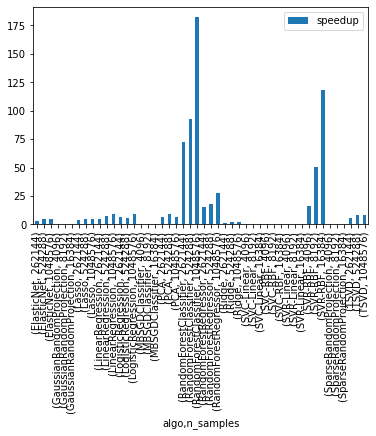

In [33]:
chart_all_algo_speedup(df)

['LinearRegression' 'LogisticRegression' 'Ridge' 'Lasso' 'ElasticNet'
 'PCA' 'TSVD' 'RandomForestClassifier' 'MBSGDClassifier'
 'RandomForestRegressor' 'GaussianRandomProjection'
 'SparseRandomProjection' 'SVC-Linear' 'SVC-RBF' 'SVR-Linear' 'SVR-RBF']


<Figure size 720x288 with 0 Axes>

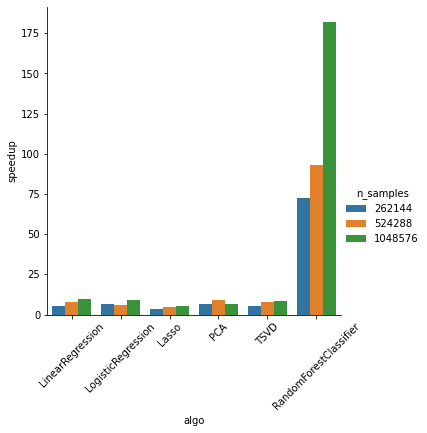

<Figure size 720x288 with 0 Axes>

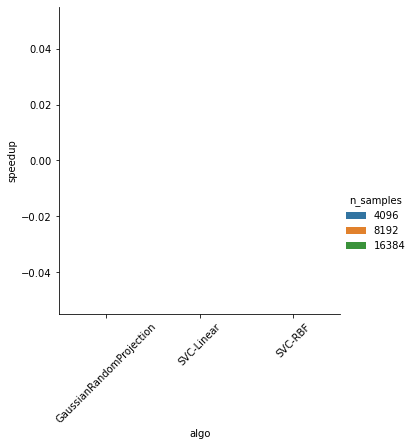

In [34]:
# Focused plots to highlight algorithms of particular interest, split by large vs. small datasets
print(df.algo.unique())

small_algos = df[df.n_samples == SMALL_ROW_SIZES[0]].algo.unique()
large_algos = df[df.n_samples == LARGE_ROW_SIZES[-1]].algo.unique()

algos_to_highlight = ["UMAP-Unsupervised", "NearestNeighbors", "KMeans", "LinearRegression", "Lasso", "GaussianRandomProjection",
                 "LogisticRegression", "PCA", "RandomForestClassifier", "TSVD", "SVC-RBF", "SVC-Linear", "DBSCAN"]
highlight_df = df[df.algo.isin(algos_to_highlight)]

import seaborn as sns
import matplotlib.pyplot as plt

for algo_list in (large_algos, small_algos):
    plt.figure(figsize=(10,4))
    current_df = highlight_df[highlight_df.algo.isin(algo_list)]
    chart = sns.catplot(x="algo", y="speedup", data=current_df, hue="n_samples", kind="bar", ci=None)
    plt.xticks(rotation=45)
    plt.show()

In [35]:
highlight_df[highlight_df.algo == 'SVC-Linea']

,cu_time,cpu_time,speedup,n_samples,n_features,algo,dataset_name,input_type


### Output Results to CSV<a id="output_csv"/>

In [ ]:
df.to_csv("benchmark_results.csv")